# Direct method
$$
    \left\{
    \begin{array}{l}
        \displaystyle \min - x_1(8), \\[0.5em]
        \dot{x}_1(t) = x_2(t) + \cos(u(t)), \; \text{for a.e. } t\in [0,8],\\[0.5em]
        \dot{x}_2(t) = \sin(u(t)),  \; \text{for a.e. } t\in [0,8], \\[0.5em]
        u(t) \in [-\frac{\pi}{2}, \frac{\pi}{2}], \; \text{for a.e. } t\in [0,8], \\[0.5em]
        x(0) = 0_{\mathbb{R}^2}, \quad x_2(8) = 4,\\[0.5em]
        \{x \in \mathbb{R}^2 \mid 5 < x_1 < 10 \} \text{ and } \{x \in \mathbb{R}^2 \mid 20 < x_1 < 25 \} \text{ are loss control regions.}
    \end{array}
    \right.
$$

In [9]:
using JuMP  
using Ipopt
using Plots
using Plots.PlotMeasures
using LaTeXStrings

In [2]:
mutable struct Direct
  t; x1; x2 ; u ; a ; b ; p1 ; p2 
end

In [6]:
function ZERMELO(x0; solution=[], nsteps=500, display=true)
    
    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",1000)
    
    N  = nsteps     # Grid size
    
    @variables(sys, begin
        x1[1:N+1]                 # x1
        x2[1:N+1]                 # x2
        -π/2 ≤ u[1:N+1] ≤ π/2     # Control
        -π/2 ≤  a       ≤ π/2 
        -π/2 ≤  b       ≤ π/2 

        end)
    
    Δt  =  8.0/(N+1) ; 
    
    # Objective
    @NLobjective(sys, Max, x1[N+1])
    
    # Boundary constraints
    @constraints(sys, begin
        con_x10, x1[1]   == x0[1]                #initial condition
        con_x20, x2[1]   == x0[2]                #initial condition
        con_x2f, x2[N+1] == 4.0                  #final condition 
        end)
    
    # Dynamics


    @NLexpression(sys, dx1[j=1:N+1], x2[j] + cos(u[j])  + (x1[j] > 5)*(x1[j] < 10)*(cos(a) - cos(u[j])) + (x1[j] > 20)*(x1[j] < 25)*(cos(b) - cos(u[j])))

    
    @NLexpression(sys, dx2[j=1:N+1], sin(u[j]) + (x1[j] > 5)*(x1[j] < 10)*(sin(a) - sin(u[j])) + (x1[j] > 20)*(x1[j] < 25)*(sin(b) - sin(u[j])))

    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j]) 
    end);
    
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end
        
    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end    
        
    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    u  = value.(u)[:]
    a  = value.(a)
    b  = value.(b)
    t  = (0:N) * value.(Δt)
    
    
    px10 =   dual(con_x10)
    px20 =   dual(con_x20)
    px2f = - dual(con_x2f)  # Modification : changement de signe

    # keep original signs for now
    sign = 1
    
     px1 = [ dual(con_dx1[i]) for i in 1:N ]
     px2 = [ dual(con_dx2[i]) for i in 1:N ]

     px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2.]; # We add the multiplier from the limit conditions
     px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2.; px2f]; # We add the multiplier from the limit conditions
    
     p1 = - [px10; px1[1:N] ]; # We add the multiplier from the limit conditions
     p2 = - [px20; px2[1:N-1]; px2f]; # We add the multiplier from the limit conditions

    return Direct(t, x1, x2, u, a, b, p1, p2)
        
end;

In [7]:
# Resolution
x0  = [0.0; 0.0]

sol_direct = ZERMELO(x0);

Solving...
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     8003
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     8000

Total number of variables............................:     1505
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      503
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1003
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 9.16e-03  -1.0 0.00e+00    -  0.00e+00

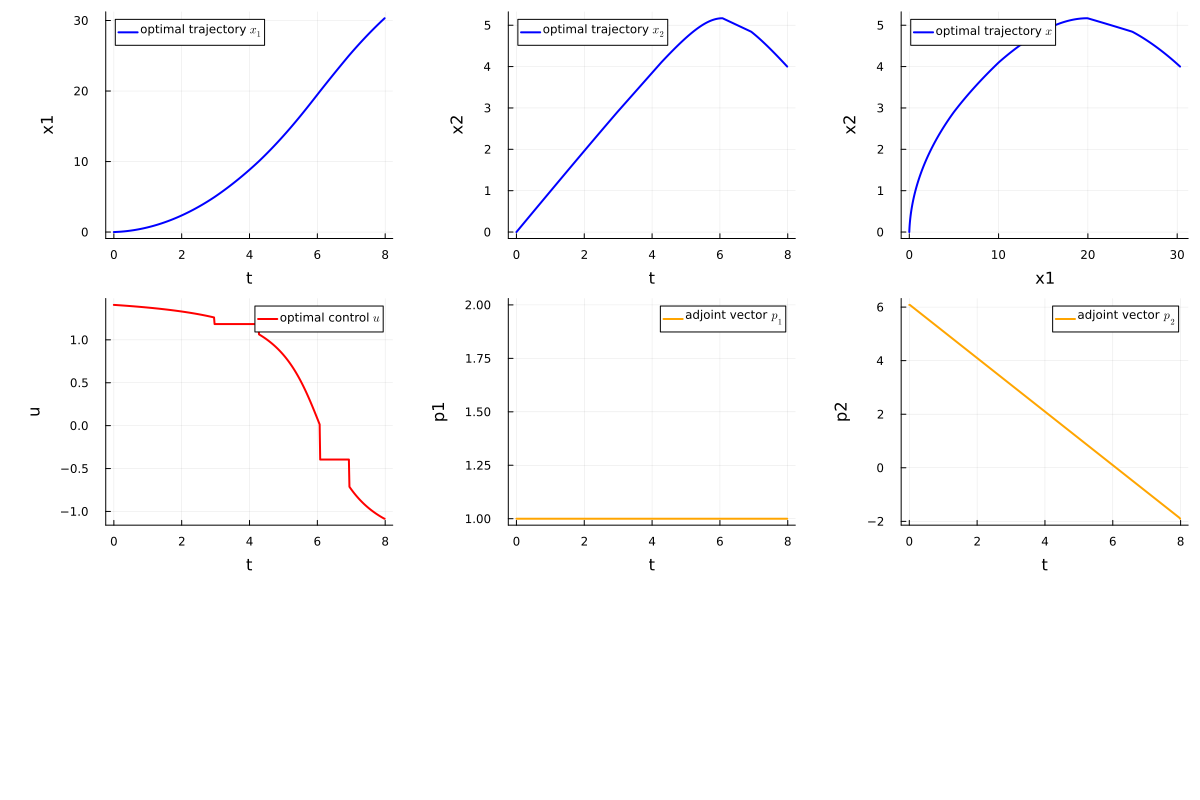

In [10]:
# Plots
t  = sol_direct.t
x1 = sol_direct.x1
x2 = sol_direct.x2
u  = sol_direct.u
a  = sol_direct.a
b  = sol_direct.b
p1  = sol_direct.p1
p2  = sol_direct.p2

idx1 = findall(abs.(x1 .- 5.0) .< 0.026)
idx2 = findall(abs.(x1 .- 10.0) .< 0.02)
idx3 = findall(abs.(x1 .- 20.0) .< 0.04)
idx4 = findall(abs.(x1 .- 25.0) .< 0.047)



 t1 = t[idx1]
 t2 = t[idx2]
 t3 = t[idx3]
 t4 = t[idx4]
 u1 = copy(u) 
 u1[t1 .<= t .<= t2] .= a
 u1[t3 .<= t .<= t4] .= b



x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  label=L"optimal trajectory $x_1$", linecolor=:blue, linewidth=2)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2", label=L"optimal trajectory $x_2$",linecolor=:blue,linewidth=2)
p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", label=L"adjoint vector $p_1$",linecolor=:orange, linewidth=2)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2", label=L"adjoint vector $p_2$",linecolor=:orange,linewidth=2)
u_plot    = plot(t,   u1, xlabel = "t", ylabel = "u",   label=L"optimal control $u$",linecolor=:red ,linewidth=2) 
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  label=L"optimal trajectory $x$", linecolor=:blue,linewidth=2)


plot(x1_plot, x2_plot, x1x2_plot, u_plot, p1_plot ,p2_plot , layout = (3,3), size=(1200,800), left_margin=10mm)

# Indirect method

In [13]:
using NLsolve
using Plots
using Plots.PlotMeasures
using Animations
using Reel
include("flow.jl");
using LinearAlgebra;

In [14]:
# Dynamics
function F(x, u)
    return [ x[2] + cos(u[1]), sin(u[1]) ]
end

function G(λ)
    return [  sin(λ), - cos(λ) ]
end

# Hamiltonians: permanent region
H1(x, u, p)  = p' * F(x, u)               # pseudo-Hamiltonian
u11(x, p)    = atan(p[2]/p[1])
Hc(x, p)     = H1(x, u11(x, p) , p )      # control

# Flows
fc  = Flow(Hc);

# Hamiltonians: control loss region 1
H2(x, a, y, p)   = p' * F(x, a)   + y* p' *G(a)          # pseudo-Hamiltonian
Hcl1(X, P)       = H2(X[1:2], X[3], X[4], P[1:2])           # control loss1

fcl1  = Flow(Hcl1);

# Hamiltonians: control loss region 1
H3(x, b, y, p)   = p' * F(x, b)   + y* p' *G(b)          # pseudo-Hamiltonian
Hcl2(X, P)       = H3(X[1:2], X[3], X[4], P[1:2])           # control loss2

# Flows
fcl2  = Flow(Hcl2);

In [23]:
t0  = 0.0
tf  = 8.0
x2f = 4.0
x0  = [0.0; 0.0]



# Shooting function
function shoot(p0, tt1, tt2, tt3, tt4, a1, b1) 
    
    pa0    = 0.0 
    pb0    = 0.0 
    py0    = 0.0
    
    x1, p1 = fc(t0, x0, p0, tt1)
    
    jump1  = p1[2]*(a1 - u11(x1, p1))/(x1[2])           # jump1

    
    X2, P2 = fcl1(tt1, [x1; a1 ; 0.0], [p1- [0. , jump1]; pa0 ; py0], tt2) # flow augmenté
    
    jump2  = P2[2]*(u11(X2[1:2], P2[1:2]) - a1)/(X2[2]) # jump2
    
    x3, p3 = fc(tt2, X2[1:2], P2[1:2] - [0. , jump2], tt3)
    
    jump3  = p3[2]*(b1 - u11(x3, p3))/(x3[2])           # jump3

    X4, P4 = fcl2(tt3, [x3; b1 ; 0.0], [p3- [0. , jump3]; pb0 ; py0], tt4)
    
    jump4  = P4[2]*(u11(X4[1:2], P4[1:2]) - b1)/(X2[2]) # jump4
 
    xf, pf = fc(tt4, X4[1:2], P4[1:2] - [0. , jump4], tf)


    s = zeros(eltype(p0), 8)
    s[1]  = xf[2] - x2f   # target
    s[2]  = pf[1] - 1.0   # transversality condition
    s[3]  = x1[1] - 5.0   # first crossing 
    s[4]  = X2[1] - 10.0  # second crossing 
    s[5]  = x3[1] - 20.0  # first crossing 
    s[6]  = X4[1] - 25.0  # second crossing 
    s[7]  = P2[3]         # averaged gradient condition1
    s[8]  = P4[3]         # averaged gradient condition2

    return s

end;

In [24]:
S(ξ) = shoot(ξ[1:2], ξ[3], ξ[4], ξ[5], ξ[6], ξ[7], ξ[8]) ;

In [25]:
ξ_guess = [p1[1], p2[1], t1[1], t2[1],t3[1],t4[1], a, b]  # initial guess

8-element Vector{Float64}:
  1.0
  6.081779867065225
  2.970059880239521
  4.263473053892215
  6.083832335329341
  6.930139720558882
  1.1842738933151067
 -0.3952643193414811

In [26]:
println("Initial value of shooting:\n", S(ξ_guess), "\n\n") ;

Initial value of shooting:
[0.12053722645419906, 0.0, -0.02532775798759168, -0.018583885853550086, -0.003588634734629892, 0.10155373219299335, -0.04350338976174054, -0.10235256362059014]




In [27]:
# Solve

indirect_sol = nlsolve(S, ξ_guess; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    pp0 = indirect_sol.zero[1:2]
    tt1 = indirect_sol.zero[3]
    tt2 = indirect_sol.zero[4]
    tt3 = indirect_sol.zero[5]
    tt4 = indirect_sol.zero[6]
    a1  = indirect_sol.zero[7]
    b1  = indirect_sol.zero[8]
else
    error("Not converged")
end;

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.205372e-01              NaN
     1     8.367195e-03     1.066693e-01
     2     1.372291e-06     2.051178e-03
     3     1.300293e-12     1.701197e-06
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0, 6.081779867065225, 2.970059880239521, 4.263473053892215, 6.083832335329341, 6.930139720558882, 1.1842738933151067, -0.3952643193414811]
 * Zero: [1.0, 5.97641676489449, 2.97433430609681, 4.265350546509287, 6.083462199447099, 6.923763932103465, 1.1801408831324627, -0.38193101623034653]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4


In [32]:
#Plots

pa0 = 0. 
pb0 = 0. 
py0 = 0.
pz0 = 0.


ode_sol = fc((t0, tt1), x0, pp0, saveat=0.1) ;
ttt1    = ode_sol.t ;
xx1     = [ ode_sol[1:2, j] for j in 1:size(ttt1, 1) ] ;
pp1     = [ ode_sol[3:4, j] for j in 1:size(ttt1, 1) ] ;
uu1     = u11.(xx1, pp1)  ;

v_1     = ode_sol[4, end]*( a1 - uu1[end])/(ode_sol[2, end])               # 1st jump condition of the adjoint vector


ode_sol = fcl1((tt1, tt2), [xx1[end] ; a1 ; 0.0], [pp1[end]- [ v_1, 0.]; pa0 ; py0], saveat=0.1)
ttt2    = ode_sol.t
xx2     = [ ode_sol[1:2, j] for j in 1:size(ttt2, 1) ]
pp2     = [ ode_sol[5:6, j] for j in 1:size(ttt2, 1) ]
uu2     = a1.*ones(length(ttt2)) ;

v_2     = ode_sol[6, end]*( u11.(xx3, pp3)[1] - a1)/(ode_sol[2, end])       # 2nd jump condition of the adjoint vector

ode_sol = fc((tt2, tt3), xx2[end],  pp2[end] - [v_2, 0.], saveat=0.1)
ttt3 = ode_sol.t
xx3 = [ ode_sol[1:2, j] for j in 1:size(ttt3, 1) ]
pp3 = [ ode_sol[3:4, j] for j in 1:size(ttt3, 1) ] 
uu3 = u11.(xx3, pp3)  ;

v_3     = ode_sol[4, end]*(b1 - uu3[end])/(ode_sol[2, end])                # 3rd jump condition of the adjoint vector

ode_sol = fcl2((tt3, tt4), [xx3[end] ; b1 ; 0.0], [pp3[end] - [v_3, 0.]; pb0 ; pz0], saveat=0.1)
ttt4 = ode_sol.t
xx4 = [ ode_sol[1:2, j] for j in 1:size(ttt4, 1) ]
pp4 = [ ode_sol[5:6, j] for j in 1:size(ttt4, 1) ] 
uu4 = b1.*ones(length(ttt4)) ;

v_4     = ode_sol[6, end]*(u11.(xx5, pp5)[1] - a1)/(ode_sol[2, end])       # 2nd jump condition of the adjoint vector
ode_sol = fc((tt4, tf), xx4[end], pp4[end]- [v_4, 0.], saveat=0.1)
ttt5 = ode_sol.t
xx5 = [ ode_sol[1:2, j] for j in 1:size(ttt5, 1) ]
pp5 = [ ode_sol[3:4, j] for j in 1:size(ttt5, 1) ] 
uu5 = u11.(xx5, pp5)  ;


t = [ ttt1 ; ttt2 ; ttt3 ; ttt4 ; ttt5]
x = [ xx1 ; xx2 ; xx3 ; xx4 ; xx5 ]
p = [ pp1 ; pp2 ; pp3 ; pp4 ; pp5 ]
u = [ uu1 ; uu2 ; uu3 ; uu4 ; uu5 ]

m = length(t)

x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  legend = false)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2",  legend = false)
p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", legend = false)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2", legend = false)
u_plot    = plot(t,   u, xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot(x1_plot, x2_plot, x1x2_plot, u_plot, p1_plot ,p2_plot , layout = (3,3), size=(900,900), left_margin=10mm)

LoadError: UndefVarError: xx3 not defined

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.


In [30]:
# create an animation
animx = @animate for i = 1:length(t)
    plot(x1[1:i], x2[1:i], xlim=(0.,31.), ylim=(0.,7.), xlabel="x1", ylabel="x2", label="x", linecolor=:blue)
end

# create an animation
animu = @animate for i = 1:length(t)
    plot(t[1:i], u[1:i], xlim=(0.,8.), ylim=(-pi/2,pi/2), xlabel="t", ylabel="u", label="u", linecolor=:red)
end 

Plots.Animation("/tmp/jl_zdtEih", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000492.png", "000493.png", "000494.png", "000495.png", "000496.png", "000497.png", "000498.png", "000499.png", "000500.png", "000501.png"])

[ Info: Saved animation to /home/anas/Documents/control-loss/animationx.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/animationx.gif")
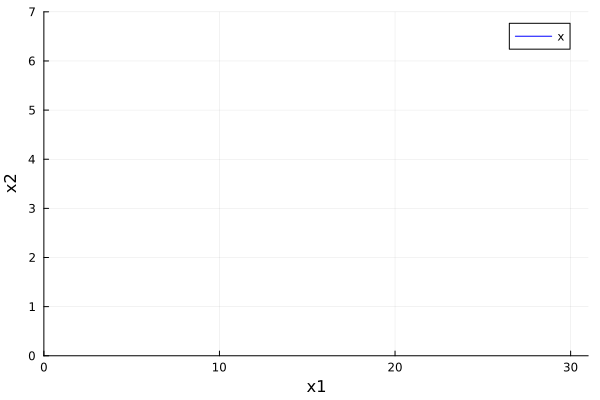

In [15]:
# display the animation
gif(animx, "animationx.gif", fps = 15)

[ Info: Saved animation to /home/anas/Documents/control-loss/animationx.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/animationx.gif")
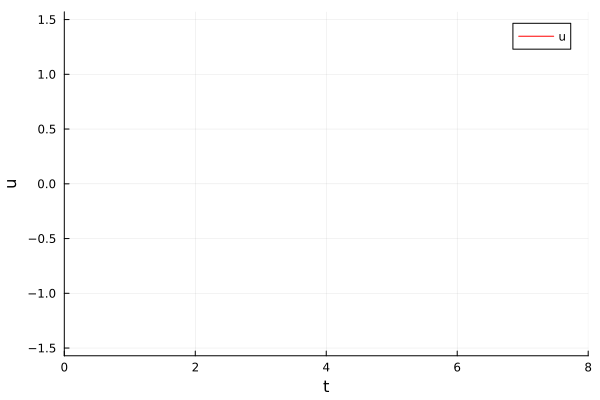

In [16]:
gif(animu, "animationx.gif", fps = 15)